# RNA + MS data integration

In [11]:
library(RColorBrewer)
library(VennDiagram)

Warning message:
“package ‘VennDiagram’ was built under R version 3.4.4”Loading required package: grid
Loading required package: futile.logger


In [12]:
# Load transformed MS data with t-test results
protFiltered = read.table("Perseus_run/ProteinsTTestFiltered.txt", sep = "\t", head=T, quote="")

In [13]:
names(protFiltered)[2] <- "LogPvalue"
# Color for significant abundance changes
protFiltered$color = ifelse(test = protFiltered$Difference > 0, "#4A91C4", "#F09F4E")
protFiltered[protFiltered$Significant != "+", 99] = "grey"
protFiltered$Gene.names <- as.character(protFiltered$Gene.names)
# Keep only the first gene name when several are provided
protFiltered[,7] <- sub(";.*", "", protFiltered[,7])

In [14]:
listDownMS = protFiltered[protFiltered$color == "#4A91C4",7]
listUpMS = protFiltered[protFiltered$color == "#F09F4E",7]

In [15]:
load("RNAlists.diff")

In [168]:
drawVennFromList = function(a, b, c = c(), d = c(), ...){
    if (is.null(c)){
        draw.pairwise.venn(length(a), length(b),
            length(intersect(a, b)), ...)
    }
    else if (is.null(d)){
        draw.triple.venn(length(a), length(b), length(c),
            length(intersect(a, b)), length(intersect(b, c)), length(intersect(a, c)), 
            length(intersect(intersect(a, b), c)), ...)          
    }
    else{
        draw.quad.venn(length(a), length(b), length(c), length(d),
            length(intersect(a, b)), length(intersect(a, c)), length(intersect(a, d)),
            length(intersect(b, c)), length(intersect(b, d)), length(intersect(c, d)),
            length(intersect(intersect(a, b), c)), length(intersect(intersect(a, b), d)),
            length(intersect(intersect(a, c), d)), length(intersect(intersect(c, b), d)),
            length(intersect(intersect(intersect(a, b), c), d)), ...)  
    }
}

In [17]:
pdf("RNA_MS_overlap.pdf")
drawVennFromList(listDownMS, listDownRNA, listUpMS, listUpRNA, category = c("MS - down", "RNA-seq - down", "MS - up", "RNA-seq - up"),
                fill = brewer.pal(4, "Paired"), fontfamily = "sans", cat.fontfamily = "sans")
dev.off()

(polygon[GRID.polygon.1], polygon[GRID.polygon.2], polygon[GRID.polygon.3], polygon[GRID.polygon.4], polygon[GRID.polygon.5], polygon[GRID.polygon.6], polygon[GRID.polygon.7], polygon[GRID.polygon.8], text[GRID.text.9], text[GRID.text.10], text[GRID.text.11], text[GRID.text.12], text[GRID.text.13], text[GRID.text.14], text[GRID.text.15], text[GRID.text.16], text[GRID.text.17], text[GRID.text.18], text[GRID.text.19], text[GRID.text.20], text[GRID.text.21], text[GRID.text.22], text[GRID.text.23], text[GRID.text.24], text[GRID.text.25], text[GRID.text.26], text[GRID.text.27]) 

pdf 
  2

In [18]:
for (i in intersect(listDownMS, listDownRNA)) cat(paste0(i, "\n"))

Rrm2
Jdp2
Top2a
Pde2a
Gstt1
Ivns1abp
Ube2c


In [19]:
for (i in union(listUpMS, listDownMS)) cat(paste0(i, "\n"))

Arhgap12
Atg7
Ppfibp2
Psmb5
Mthfd2
Rbpj
Hfe
Vasp
C1qc
Iqgap2
Tgfbrap1
Stxbp3
Asns
Emr1
Trmt61a
Dennd6a
Sgta
9030624J02Rik
Txnl1
Yars
Lpxn
Snx2
Iqgap1
Sqrdl
Ehd1
Ktn1
Nudt16
Fcgr4
Slfn9
Acsl1
Smc4
Myo1e
Nrp2
F5
Ltf
Rrm2
Mpo
Ass1
Alox15
Msh2
Epx
Polr3b
Tgfbi
Jdp2
Top2a
Itprip
Pde2a
Lig1
Phactr4
Pes1
Cluh
Adck3
Fscn1
Tgtp1
Gstt1
Top2b
Syne1
Brd2
Mybbp1a
Prss34
Bsdc1
Nt5dc1
Rrp9
Ivns1abp
Cyp4f3
Serpinb1a
Ube2c
Cd97


In [20]:
for (i in intersect(listUpMS, listUpRNA)) cat(paste0(i, "\n"))

Mthfd2
Asns


In [21]:
for (i in listUpRNA) cat(paste0(i, "\n"))

Mfsd6
Cd28
Dner
Glrp1
Cyb5r1
Fam129a
Ly9
Slamf7
Atf3
Sgk1
Mfsd4b3
Smpdl3a
NA
Aldh1l2
Plxnc1
Avil
Ddit3
Esyt1
Grb10
Slc1a4
Sept8
Pmp22
Zbtb4
Nlrp1b
Mmp28
Nfe2l1
Atp6v0a1
Arsg
Cd300a
Slc26a11
Pycr1
Metrnl
Etv1
Acot2
Gpr141
Rnf144b
Mctp1
Rnf180
Zcchc24
Ghitm
Ptger2
Rnase4
Pck2
Sorbs3
Matn2
Ndrg1
Igfbp6
Soat2
Dgkg
Itgb5
Cd86
Cd200r1
Cd200r4
Trp53cor1
Gtpbp2
Ticam2
Afap1l1
Tmem151a
Slc3a2
Phyhd1
Stom
Tnks1bp1
Ldlrad3
Lmo2
Arl14ep
Chac1
Sqor
Cd93
Trib3
Mafb
Tox2
Sirpb1a
Sirpb1b
LOC100038947
Tmem154
Trim46
Phgdh
Cd53
S1pr1
Mcoln3
Ptger3
Cth
Bach2os
Klf4
Slc6a9
Sesn2
Dhrs3
Car6
Rell1
Cxcl2
Hpse
Gbp8
Psph
Amz1
Tecpr1
Pon2
Asns
Cped1
Gadd45a
Sh2d6
Mthfd2
Clec4n
Cebpg
Atf5
Cpeb1
Il16
Tsku
Eef2k
Gm20367
Nupr1
Cox6a2
Cdkn1c
Slc22a18
Gdf15
Lyl1
Slc38a7
Aars
Nrp1
Mmp13
Aqp9
Plscr4
Slc9a9
Als2cl
L1cam
Mpp1


## Prepare PPI for Omics Integrator
The PPI was obtained from BioGRID Release 3.4.160 as [all the interactions available for mice in the TAB2 format](https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.4.160/BIOGRID-ORGANISM-3.4.160.tab2.zip).

In [37]:
PPI = read.table("OmicsIntegratorRun/BIOGRID-ORGANISM-Mus_musculus-3.4.160.tab2.txt", sep = "\t", header = T,
                quote = '', na.strings = "-", comment.char = "")
head(PPI[,c(8,9)])

Official.Symbol.Interactor.A,Official.Symbol.Interactor.B
SMAD2,Rasd2
SMAD2,Rab34
SMAD2,Rhebl1
SMAD2,Rab38
SMAD2,Rhobtb1
SMAD2,Arhgef7


In [38]:
names(PPI)

[1] "X.BioGRID.Interaction.ID"     "Entrez.Gene.Interactor.A"    
 [3] "Entrez.Gene.Interactor.B"     "BioGRID.ID.Interactor.A"     
 [5] "BioGRID.ID.Interactor.B"      "Systematic.Name.Interactor.A"
 [7] "Systematic.Name.Interactor.B" "Official.Symbol.Interactor.A"
 [9] "Official.Symbol.Interactor.B" "Synonyms.Interactor.A"       
[11] "Synonyms.Interactor.B"        "Experimental.System"         
[13] "Experimental.System.Type"     "Author"                      
[15] "Pubmed.ID"                    "Organism.Interactor.A"       
[17] "Organism.Interactor.B"        "Throughput"                  
[19] "Score"                        "Modification"                
[21] "Phenotypes"                   "Qualifications"              
[23] "Tags"                         "Source.Database"

In [39]:
# Map an experimental system to a confidence score for direct PPI
expScore = data.frame(levels(PPI$Experimental.System), c(0.2,0.2,0.2,0.2,0.99,0.5,0.2,0.2,0.2,
  0,0,0.99,0.99,0,0.99,0,0,0,
  0.99,0.2,0.2,0.99,0,0,0,0,0.99))
expScore

levels.PPI.Experimental.System.,c.0.2..0.2..0.2..0.2..0.99..0.5..0.2..0.2..0.2..0..0..0.99..0.99..
Affinity Capture-Luminescence,0.20
Affinity Capture-MS,0.20
Affinity Capture-RNA,0.20
Affinity Capture-Western,0.20
Biochemical Activity,0.99
Co-crystal Structure,0.50
Co-fractionation,0.20
Co-localization,0.20
Co-purification,0.20
Dosage Growth Defect,0.00


In [40]:
PPI$expScore = expScore[PPI$Experimental.System,2] # Levels = row index in the lookup table

In [ ]:
write.table(PPI[,c(8,9,25),], file = "OmicsIntegratorRun/mousePPI.tsv", col.names = F, row.names = F, sep = "\t",
            quote = F, dec = ".")

## Combine Omics Integrator networks
We first combine the optimal forests for the three comparisons and export an annotated version of the union of these nodes and their direct neighbors, with all known edges between these nodes.

In [25]:
library(igraph)
recNodes = unique(unlist(read.table("OmicsIntegratorRun/recArg1_output/result_optimalForest.sif")[,c(1,3)]))
ranklNodes = unique(unlist(read.table("OmicsIntegratorRun/ranklDiff_output/result_optimalForest.sif")[,c(1,3)]))
deplNodes = unique(unlist(read.table("OmicsIntegratorRun/deplOrRec_output/result_optimalForest.sif")[,c(1,3)]))

(polygon[GRID.polygon.125], polygon[GRID.polygon.126], polygon[GRID.polygon.127], polygon[GRID.polygon.128], polygon[GRID.polygon.129], polygon[GRID.polygon.130], text[GRID.text.131], text[GRID.text.132], text[GRID.text.133], text[GRID.text.134], text[GRID.text.135], text[GRID.text.136], text[GRID.text.137], text[GRID.text.138], text[GRID.text.139]) 

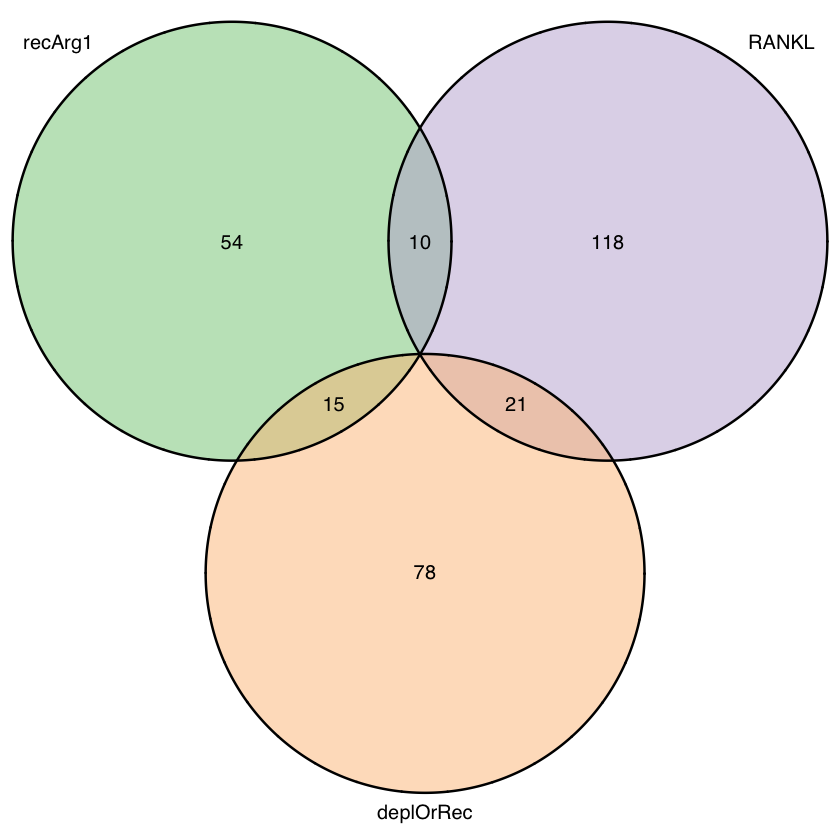

In [169]:
drawVennFromList(recNodes, ranklNodes, deplNodes, c(), category = c("recArg1", "RANKL", "deplOrRec"),
                fill = brewer.pal(3, "Accent"), fontfamily = "sans", cat.fontfamily = "sans")

In [115]:
forestNodes = union(union(recNodes, ranklNodes), deplNodes)
PPI$Official.Symbol.Interactor.A = as.character(PPI$Official.Symbol.Interactor.A)
PPI$Official.Symbol.Interactor.B = as.character(PPI$Official.Symbol.Interactor.B)
neighbors = union(PPI$Official.Symbol.Interactor.B[PPI$Official.Symbol.Interactor.A %in% forestNodes],
PPI$Official.Symbol.Interactor.A[PPI$Official.Symbol.Interactor.B %in% forestNodes])
allNodes = union(forestNodes, neighbors)
length(allNodes)

[1] 4380

In [116]:
interactionsWithNeighbors = ((PPI$Official.Symbol.Interactor.A %in% allNodes) | (PPI$Official.Symbol.Interactor.B %in% allNodes)) & 
    (PPI$Official.Symbol.Interactor.A != PPI$Official.Symbol.Interactor.B)
neighborsPPI = graph_from_edgelist(as.matrix(PPI[interactionsWithNeighbors, c(8,9)]))
A = as.matrix(as_adjacency_matrix(neighborsPPI))

In [130]:
allNodes = union(names(which(colSums(A[rownames(A) %in% forestNodes,]) >= 2)), forestNodes)
length(allNodes)

[1] 1342

In [146]:
interactionsWithForests = ((PPI$Official.Symbol.Interactor.A %in% allNodes) & (PPI$Official.Symbol.Interactor.B %in% allNodes)) & 
    (PPI$Official.Symbol.Interactor.A != PPI$Official.Symbol.Interactor.B)
expandedForest = graph_from_edgelist(as.matrix(PPI[interactionsWithForests, c(8,9)]))
all(names(V(expandedForest)) %in% allNodes)

[1] TRUE

In [172]:
nodeType = rep(0, vcount(expandedForest))
nodeType = nodeType + sapply(names(V(expandedForest)), function(x) ifelse(x %in% recNodes, 1, 0))
nodeType = nodeType + sapply(names(V(expandedForest)), function(x) ifelse(x %in% ranklNodes, 2, 0))
nodeType = nodeType + sapply(names(V(expandedForest)), function(x) ifelse(x %in% deplNodes, 4, 0))
table(nodeType)
expandedForest = set_vertex_attr(expandedForest, name = "nodeType", value = nodeType) 

nodeType
   0    1    2    3    4    5    6 
1046   54  118   10   78   15   21 

In [183]:
write_graph(expandedForest, "OmicsIntegratorRun/allForestsWithNeighbors.gml", format = "gml")
write_graph(induced_subgraph(expandedForest, which(nodeType != 0)), "OmicsIntegratorRun/allForests.gml", format = "gml")

In [ ]:
sessionInfo()